In [52]:
'Q2: Fish Dataset Regression Analysis'
'Task 1: Linear regression'
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
# Load dataset
data = pd.read_csv("Downloads/fish.csv")

In [4]:
# Define predictors (X) and target (y)
X = data[["Length1", "Length2", "Length3", "Height", "Width"]].values
y = data["Weight"].values

In [5]:
# Split into training testing and validation sets
# First split: 80% train_val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 70% train, 10% val (0.125 of 80% = 10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [53]:
# Convert y 1D arrays
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
y_test = np.ravel(y_test)

Iteration 0: Cost 136936.9174
Iteration 500: Cost 8011.7345
Iteration 1000: Cost 7997.2280
Iteration 1500: Cost 7991.7104
Iteration 2000: Cost 7987.4743
Iteration 2500: Cost 7983.6328
Iteration 3000: Cost 7979.9467
Iteration 3500: Cost 7976.3508
Iteration 4000: Cost 7972.8263
Iteration 4500: Cost 7969.3675

--- Gradient Descent Results ---
Length1: 10.2400
Length2: 8.8507
Length3: 3.6568
Height: 8.3273
Width: 48.8374
Intercept: -532.5338


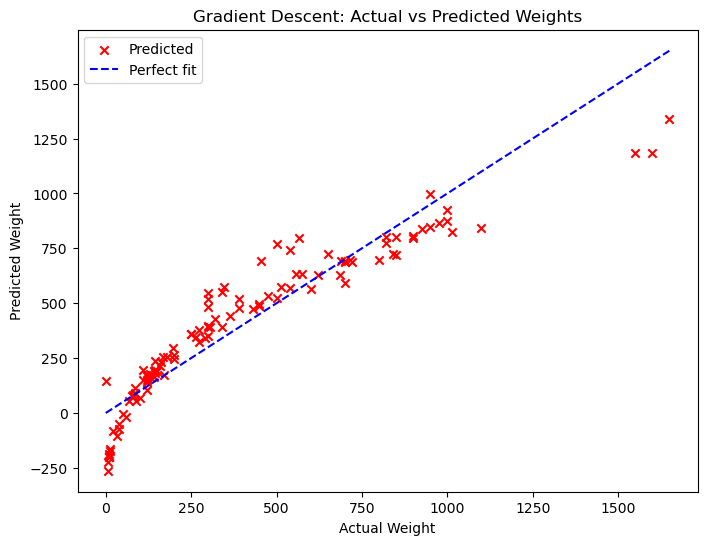

In [54]:
# Feature normalization for Gradient Descent
# -------------------------------
# Compute mean and std of each feature
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std  # normalized features

# Gradient Descent Functions
def compute_cost(X, y, w, b):
    m = X.shape[0]
    predictions = X.dot(w) + b
    cost = (1 / (2*m)) * np.sum((predictions - y)**2)
    return cost

def gradient_descent(X, y, w, b, alpha, num_iters):
    m = X.shape[0]
    J_history = []

    for i in range(num_iters):
        predictions = X.dot(w) + b
        error = predictions - y

        dj_dw = (1/m) * X.T.dot(error)
        dj_db = (1/m) * np.sum(error)

        w -= alpha * dj_dw
        b -= alpha * dj_db

        cost = compute_cost(X, y, w, b)
        J_history.append(cost)

        if i % 500 == 0:
            print(f"Iteration {i}: Cost {cost:.4f}")

    return w, b, J_history

# Run Gradient Descent
column_names = ["Length1", "Length2", "Length3", "Height", "Width"]
w_init = np.zeros(X_train.shape[1])
b_init = 0.
alpha = 0.01
iterations = 5000

w_norm, b_final, J_hist = gradient_descent(X_train_norm, y_train, w_init, b_init, alpha, iterations)
w_final = w_norm / X_std
b_final_original = b_final - np.sum((X_mean / X_std) * w_norm)

print("\n--- Gradient Descent Results ---")
for i, name in enumerate(column_names):
    print(f"{name}: {w_final[i]:.4f}")
print(f"Intercept: {b_final_original:.4f}")

# Predicted vs Actual (GD)
predicted = np.dot(X_train, w_final) + b_final_original
plt.figure(figsize=(8,6))
plt.scatter(y_train, predicted, c='red', marker='x', label='Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b--', label='Perfect fit')
plt.xlabel("Actual Weight")
plt.ylabel("Predicted Weight")
plt.title("Gradient Descent: Actual vs Predicted Weights")
plt.legend()
plt.show()

In [55]:
# OLS / Standard Linear Regression
# Add intercept
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

print("\n--- OLS / Linear Regression ---")
predictor_names = ["Intercept"] + column_names
for i, name in enumerate(predictor_names):
    print(f"{name}: Coefficient = {ols_model.params[i]:.4f}, Standard Error = {ols_model.bse[i]:.4f}")
print(f"R-squared: {ols_model.rsquared:.4f}")


--- OLS / Linear Regression ---
Intercept: Coefficient = -516.3468, Standard Error = 37.7596
Length1: Coefficient = 40.4611, Standard Error = 52.9132
Length2: Coefficient = 12.6287, Standard Error = 53.7468
Length3: Coefficient = -26.3928, Standard Error = 20.0651
Height: Coefficient = 22.5704, Standard Error = 10.1970
Width: Coefficient = 24.7157, Standard Error = 23.7310
R-squared: 0.8812



--- Ridge Regression ---
Alpha: 1.0
Length1: Coefficient = 36.5078, Standard Error = 41.6322
Length2: Coefficient = 15.4961, Standard Error = 42.8079
Length3: Coefficient = -25.5423, Standard Error = 19.5021
Height: Coefficient = 22.0495, Standard Error = 10.0276
Width: Coefficient = 25.0104, Standard Error = 22.9962
R-squared (Test): 0.8814


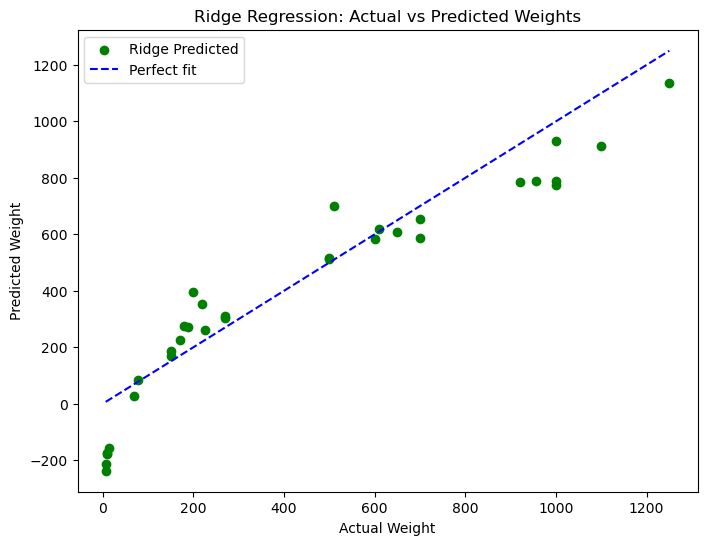

In [56]:
'Task 2 Ridge and Lasso Regression'
# ---------Ridge Regression-------------#
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict on test set
ridge_pred_test = ridge_model.predict(X_test)

# Residuals and variance based on test set
residuals_ridge = y_test - ridge_pred_test
sigma2_ridge = np.var(residuals_ridge, ddof=X_train.shape[1]+1)

# Covariance matrix for approximate SE
XtX = X_train.T @ X_train
alpha_I = ridge_model.alpha * np.eye(X_train.shape[1])
cov_ridge = sigma2_ridge * np.linalg.inv(XtX + alpha_I) @ XtX @ np.linalg.inv(XtX + alpha_I)
se_ridge = np.sqrt(np.diag(cov_ridge))

print("\n--- Ridge Regression ---")
print(f"Alpha: {ridge_model.alpha}")
for name, coef, se in zip(column_names, ridge_model.coef_, se_ridge):
    print(f"{name}: Coefficient = {coef:.4f}, Standard Error = {se:.4f}")
print(f"R-squared (Test): {r2_score(y_test, ridge_pred_test):.4f}")

# Predicted vs Actual (Ridge)
plt.figure(figsize=(8,6))
plt.scatter(y_test, ridge_pred_test, c='green', marker='o', label='Ridge Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', label='Perfect fit')
plt.xlabel("Actual Weight")
plt.ylabel("Predicted Weight")
plt.title("Ridge Regression: Actual vs Predicted Weights")
plt.legend()
plt.show()


--- Lasso Regression ---
Alpha: 0.1
Length1: Coefficient = 49.1529, Standard Error = 52.1968
Length2: Coefficient = 2.1800, Standard Error = 54.0780
Length3: Coefficient = -24.3211, Standard Error = 20.5321
Height: Coefficient = 22.2052, Standard Error = 10.4606
Width: Coefficient = 26.1330, Standard Error = 24.0407
R-squared (Test): 0.8821


C:\Users\Spruha Vinayak\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.323e+05, tolerance: 1.454e+03
  model = cd_fast.enet_coordinate_descent(


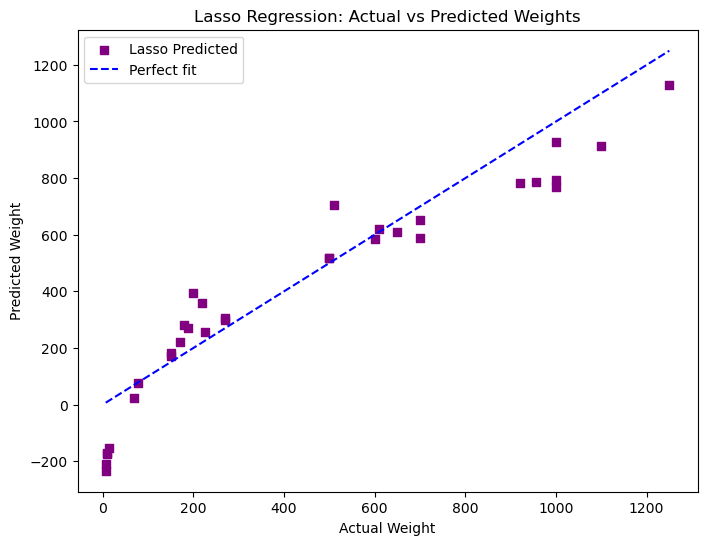

In [57]:
# ---------------- Lasso Regression ----------------
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Predict on test set
lasso_pred_test = lasso_model.predict(X_test)

# Residuals and variance based on test set
residuals_lasso = y_test - lasso_pred_test
sigma2_lasso = np.var(residuals_lasso, ddof=X_train.shape[1]+1)

# Covariance matrix for approximate SE
alpha_I_lasso = lasso_model.alpha * np.eye(X_train.shape[1])
cov_lasso = sigma2_lasso * np.linalg.inv(XtX + alpha_I_lasso) @ XtX @ np.linalg.inv(XtX + alpha_I_lasso)
se_lasso = np.sqrt(np.diag(cov_lasso))

print("\n--- Lasso Regression ---")
print(f"Alpha: {lasso_model.alpha}")
for name, coef, se in zip(column_names, lasso_model.coef_, se_lasso):
    print(f"{name}: Coefficient = {coef:.4f}, Standard Error = {se:.4f}")
print(f"R-squared (Test): {r2_score(y_test, lasso_pred_test):.4f}")

# Predicted vs Actual (Lasso)
plt.figure(figsize=(8,6))
plt.scatter(y_test, lasso_pred_test, c='purple', marker='s', label='Lasso Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', label='Perfect fit')
plt.xlabel("Actual Weight")
plt.ylabel("Predicted Weight")
plt.title("Lasso Regression: Actual vs Predicted Weights")
plt.legend()
plt.show()